## 💻 UnpackAI DL201 Bootcamp - Week 2 - Skills: Preprocessing Image Data

### 📕 Learning Objectives

* Have an appreciation for the diversity of image preprocessing tasks in various situations and that no one size fits all solution exists
* Gain an understanding of **spacial filtering**, the principles of how it works from a code based perspective, and how to apply to remove noise, sharpen edges, and detect edges
* Grasp the concept of thresholding, and appreciate how it can be a powerful tool
* Understand the difference between local and global thresholding, and the challenges involved. 

### 📖 Concepts map

* Spacial Filtering
* Thresholding
* Image Masking
* Global vs Local




In [2]:
!pip install openpyxl wand
!git clone https://github.com/unpackAI/DL201.git


import pandas as pd
import numpy as np
import cv2 
import torch as t
from matplotlib import pyplot as plt

# Imports 
from pathlib import Path

#Kaggle config
DATA_DIR = Path('/kaggle/working/DL201/data') #uncomment for kaggle
IMAGE_DIR = Path('/kaggle/working/DL201/img') #Uncomment for Kaggle


# Local Config
#DATA_DIR = Path.home()/'Datasets'/'unpackAI'/'DL201'/'data'
#IMAGE_DIR = Path('../img') #uncomment for local machine

# I. Why Preprocess Images?

### Do I need to know advanced mathemathics to preprocess images? 

While there's always some level of math involved, but that is not always necessary to implement the algorithms. 

In Fact, one of the most common ways to extract features before deep learning was SIFT. This was a very complex algorithm that few people understand completely, but is heavily cited as a method. 

Likewise, you don't need to impliment a fourier transform from scratch, as long as you can understand the outputs of it, and what they mean towards accomplishing the objective of cleaning the data.

To use these algoriths doesn't need a lot of math beyond a basic understanding of matrix operations to the extent that it allows the concepts of what the transforms are trying to do can sink in.


### What are the Challenges of Image Preprocessing?


Although Image Proprocessing requires knowledge of many algos, but it's application dependent. You don't have to learn every method under the sun to be effective.  

In some situations some approaches may be more advantageous than others. Some data may not need preprocessing if the model is trained by images uploaded by users that are taken in a variety of lighting conditions, while others, such in an industrial setting, may require preprocessing to increase performance in order to highlight defective product that can be removed from the line.  



### How does this apply to medical images? 

When using a pretrained model that is trained on color images, it may make sense to preprocess x-rays and MRIs using a technique by extending the grayscale specture to all that covered by visible light that cameras pick up.

This is because x-rays and MRIs are often black and white or the same shade of color. By expanding the color spectrum to include more color, it can highlight features that would be more difficult to spot otherwise. 

### Resnet Example

In [33]:
from PIL import Image

import IPython.display
import cv2

braintumor = Image.open(IMAGE_DIR/'week2/braintumor.jpg')

In [32]:
grayscale = np.array(braintumor)
grayscale.shape

(899, 723)

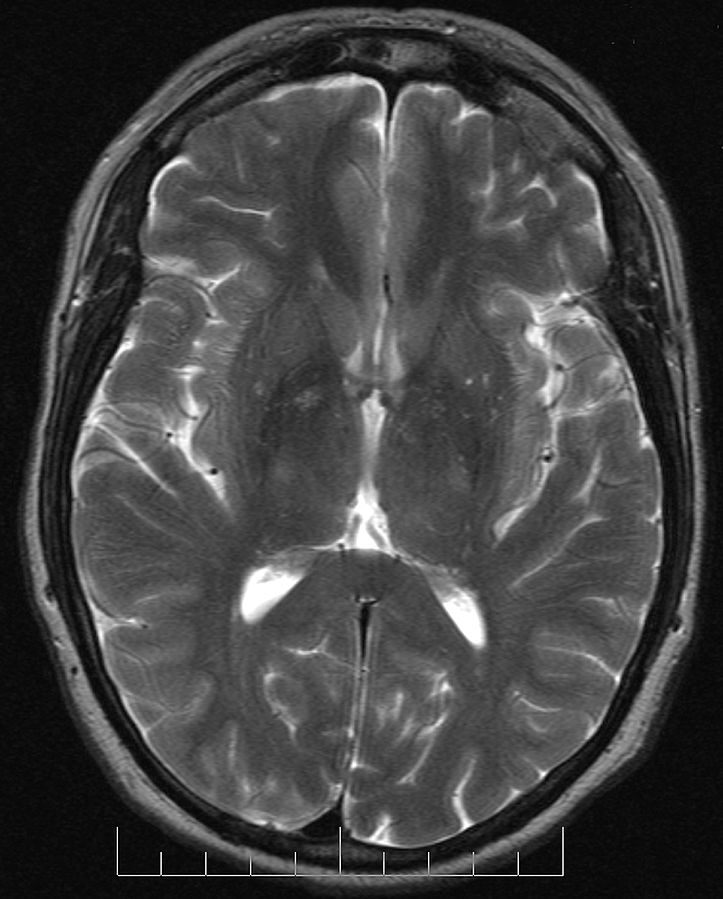

In [38]:
IPython.display.Image(IMAGE_DIR/'week2/braintumor.jpg',
                      width=250,height=250)

In [34]:
pseudoColoredImage = cv2.applyColorMap(grayscale, cv2.COLORMAP_JET)

In [35]:
pseudoColoredImage.shape

(899, 723, 3)

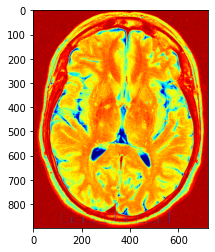

In [39]:
plt.imshow(pseudoColoredImage)
plt.show()

### What Methods are There to Preprocess Images?

There are many ways to do this, but two main categories are Spacial Filters and Frequency Filters. Both treat the problem differently, and are used in different situations. 

In this notebook, we'll go into Spacial Filters because they are related to the concepts learned in the first week and build on top of them. 

## II. What is a Spacial Filter?

A Spacial Filter uses the principle of using the information in neighboring pixels to be able to correct, restore, or enhance the image. 

In [268]:
example_img_path = str(IMAGE_DIR/'week2/chimpanzee.jpg')
example_img = cv2.imread(example_img_path)

### How do they work?

This is done using a mask, which is a small 3x3 or larger matrix that is moved across all of the pixels. Here is an example where we will add some noise to an image.

In [269]:
import wand.image
  
# Read image using Image() function
with wand.image.Image(filename=example_img_path)as noisy_img:
  
    # Generate noise image using spread() function
    noisy_img.noise("gaussian", attenuate = 0.9)
    noisy_img.save(filename =IMAGE_DIR/'week2'/"noisyExample.jpg")


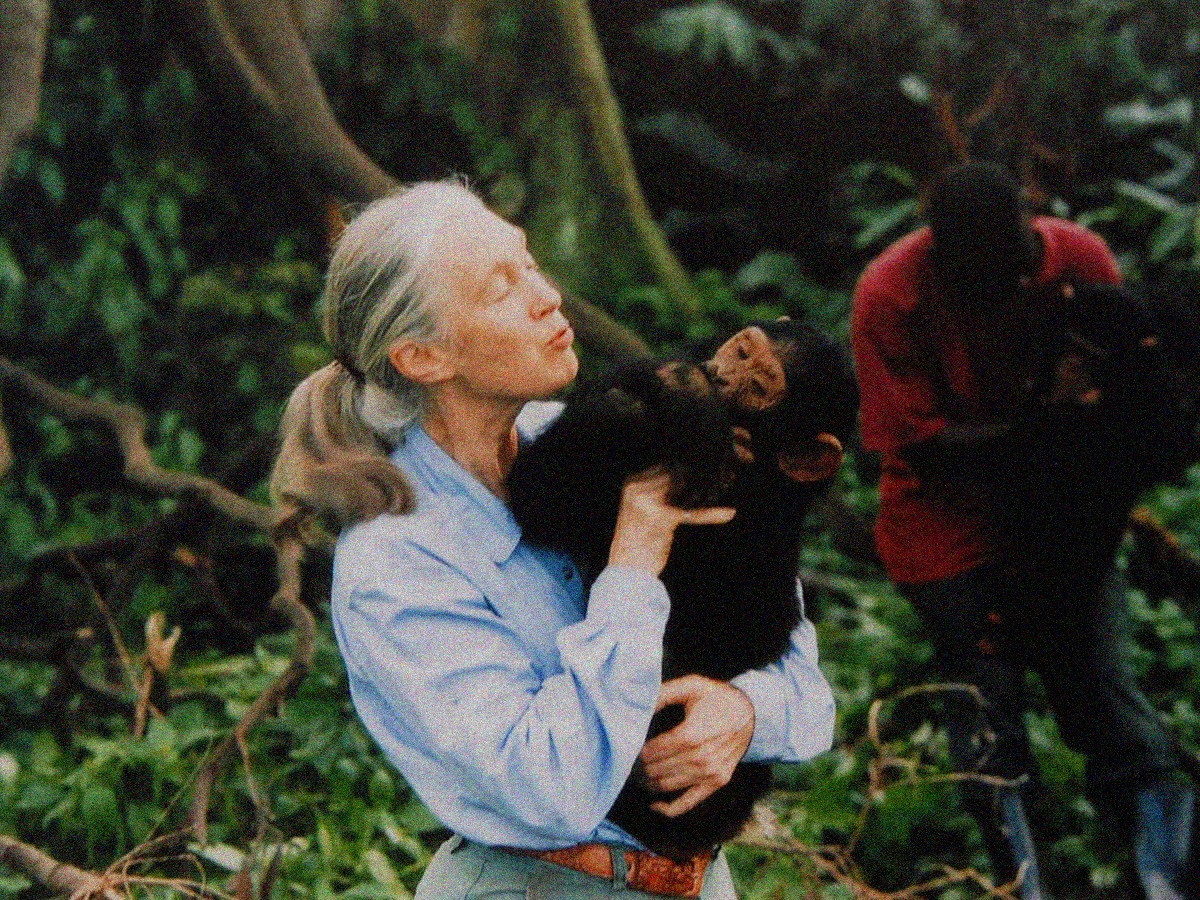

In [270]:
noisy_img = cv2.imread(str(IMAGE_DIR/'week2'/"noisyExample.jpg"))
IPython.display.Image(IMAGE_DIR/'week2/noisyExample.jpg',
                      width=250,height=250)

This image now has some noise added to it. The goal of this exercise is to extract more features from the chimpanzees in the background of the image.

## Noise Removal (Blurring?)

A mean filter takes the values of all the pixels surrounding it, and applying it to that pixel. It does this across the entire image.

In [271]:

means_filtered_img = cv2.fastNlMeansDenoisingColored(noisy_img,None,10,10,7,21)


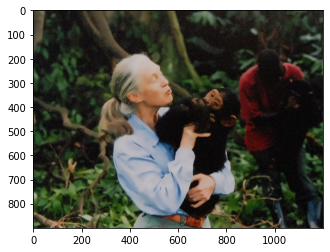

In [272]:
plt.imshow(cv2.cvtColor(means_filtered_img, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

## Image Enhancement

After image correction, Spacial Filters can be used to sharpen images. By taking the derivatives of the pixel values in a 2D space, this will highlight edges and features that had too much texture to stand out in the original image.

It is also possible to do it in a way where sharp differences in pixel values are increased by the mask with the zero and negative values not affecting flat areas, but picking up differences strongly.

### Sharpening an Image


In [150]:
grayscale_example = cv2.cvtColor(example_img, cv2.COLOR_RGB2GRAY)

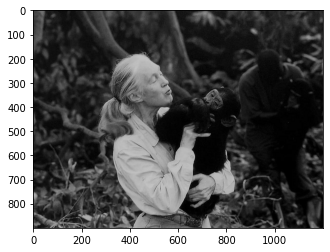

In [320]:
kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

img_sharp = cv2.filter2D(grayscale_example,-1, kernel)

plt.imshow(cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

# III. Thresholding 

The goal of thesholding is to identify and segment the foreground and background of an image. 



### When is thresholding used?

This solves a variety of problems such as uneven lighting, hidden features, or even noise present in the background which may affect the model's performance.

Identifying a threshold is an important part of image preprocessing because it allows one to be much more precise.

### How can a threshold be identified?

There are many ways to identify a threshold, but the most simple one is by taking the mean, and looking for two normal distributions.

### Histogram based thresholding (Colors)

Uses the mean pixel values

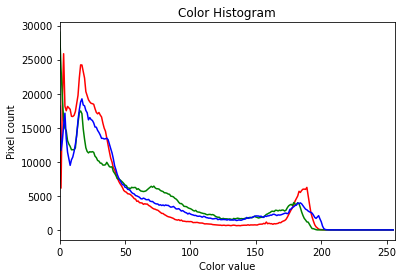

In [280]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        example_img[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

This graph shows two distinct places where many values are contained and identifies where to put a threshold. 

### Edge Based Segmentation


Another highly versatile method is to use edge detection to be able to apply adaptive thresholding. 

In [281]:
# Step 1 

g_blurred = cv2.GaussianBlur(example_img, (5, 5), 0)

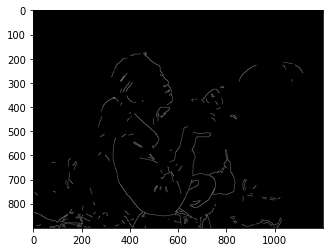

In [282]:
# Thresholds 
t_lower = 150
t_upper = 210

edge = cv2.Canny(g_blurred, t_lower,t_upper)

plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

# V. Local Transforms (Masking)

Once we have identified a threshold, it becomes possible to preprocess an image in the areas where it needs it most.

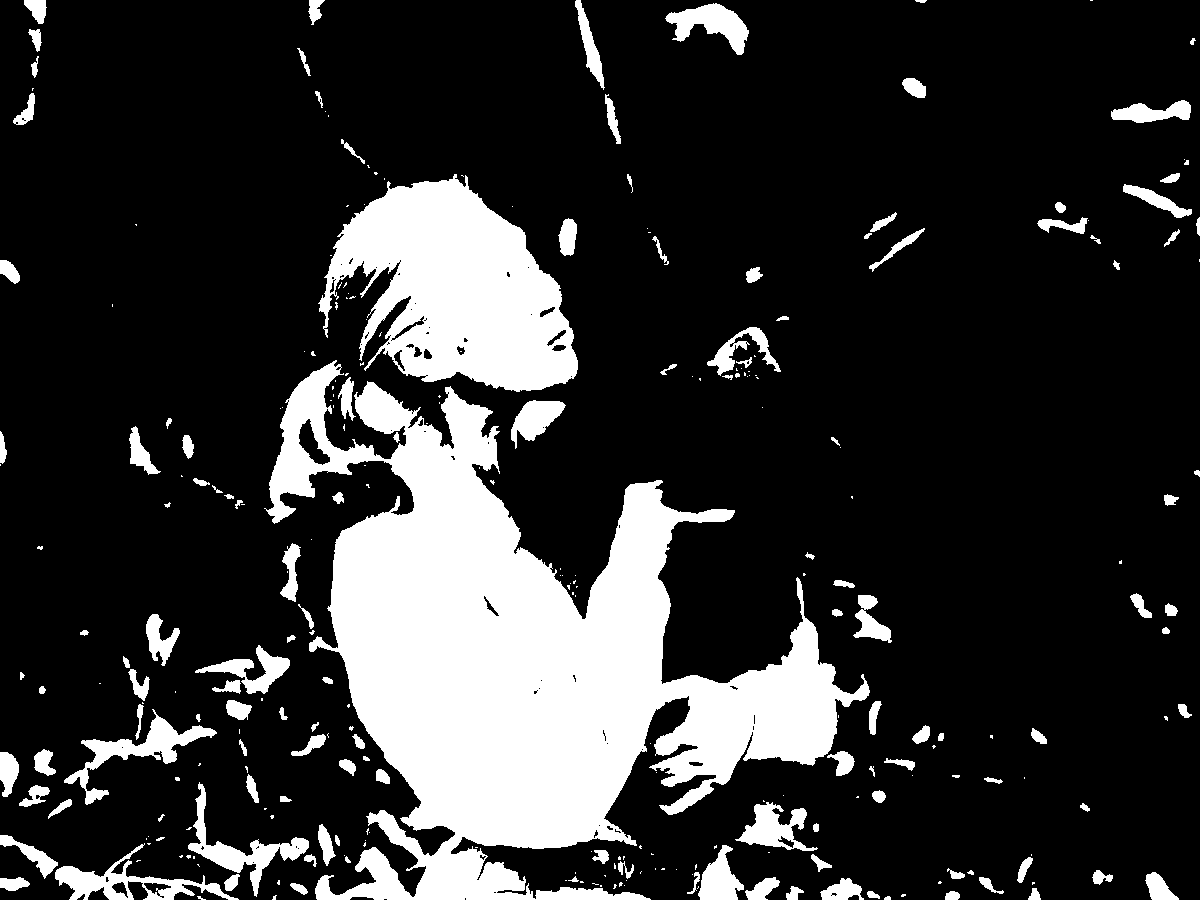

In [305]:

mask = example_img.copy()
value_threshold = 90
background = (grayscale_example <= value_threshold)
display(Image.fromarray(foreground))

### Background Removal

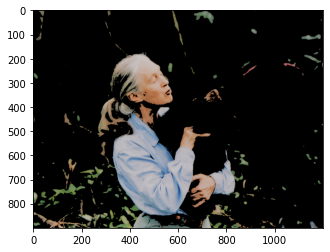

In [306]:
foreground = np.where(foreground[...,None],example_img,0)
background = np.where(background[...,None],example_img,0)
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

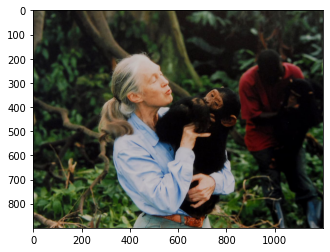

In [307]:
img_added = foreground + background
plt.imshow(cv2.cvtColor(img_added, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

### Brightness  

In [318]:
alpha = 1.5 # Kept Constant: Higher than 1.0 increases contrast, lower than 1.0 decreases
beta = 50 # A coefficient to increase the pixel values

background_adjusted = cv2.convertScaleAbs(background,alpha=alpha,beta=beta)

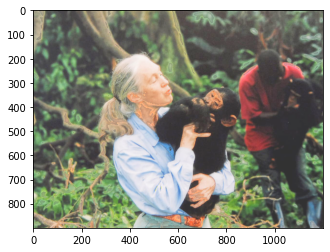

In [319]:
img_adjusted = foreground + background_adjusted
plt.imshow(cv2.cvtColor(img_adjusted, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

### 